Your name: Huy Tran

Your student ID number: 33259590

Shared link to this notebook: https://github.com/hvtran21/cs446_p2

# Programming Assignment 2 (P2) for COMPSCI 446, Search Engines

_This is an updated version of the notebook for P2. Please watch Piazza for announcements of new versions and/or check back periodically to see if it has been updated._

_As of this version of the notebook, the autograder is set up in Gradescope._


The purpose of this project is to explore and implement some of the effectiveness measures discussed in class and in the text (Section 8.4). You will implement a function called eval that will be invoked as follows:
```python
eval(trecrunFile, qrelsFile, outputFile)
```

where `trecrunFile` and `qrelsFile` are files that we will provide to you and `outputFile` is where you will print the evaluation results of the trecrun file.

A trecrun file contains the actual system runs that you are going to evaluate. It is a text file with six space-separated columns on every line (note that for obvious reasons, no column can contain spaces):
- The first column is the query name (aka query id)
- The second column is unused and should always contain "skip" (for historical reasons)
- The third column is a document identifier (“docid”)
- The fourth column is the rank of that document for that query in this run
- The fifth column is the score from the retrieval model.
- The sixth column is some text to describe the run itself, normally the same for every line in the file.

The qrels file contains judgment information: given a query and a document, is the document relevant to the query? It is another space-separated text file:
- The first column is the query name/id (corresponding to the query name/id in the trecrun files)
- The second column is unused (it is present for historical reasons; you won't need to do anything with it except be sure you read it to get to the remaining columns)
- The third column is a document identifier (“docid”)
- The fourth column is a number representing the relevance of the document, either 0 for non-relevant, or positive for relevant.

We will provide a common qrels file as well as several trecrun files and sample output files. We will also provide copies of the queries in case you find it useful, though they aren't needed.

Note that for many of the query-docid pairs in the trecrun file, you will find a corresponding pair in the qrels file, helping you to evaluate how well the retrieval model did for that query. However, as discussed in class, **large numbers of query-docid pairs will be unjudged, so will not appear in the qrels file. When you encounter that, you should assume that the query-docid pair is non-relevant** (i.e., has a relevance score of zero).

Your code will read in the provided trecrun and qrels files. It will then generate evaluation scores and print them in a particular format (see below) to the indicated output filename.




# 0. Setup

In [280]:
version = 2 # DO NOT MODIFY. If notebook does not match with autograder version, many tests are likely to fail!!



We first execute the following to connect to Google Drive (you will be prompted repeatedly for access to your Google Drive; please give it permission) and download copies of the sample files listed above. You should not need to make any modifications to the code, though if you want to use a slightly different path in Google Drive, you can modify the appropriate data_path value. (The autograder will not use your Google Drive.)

In [281]:
import os
import string
import gzip
import re

import math
import sys
from collections import defaultdict

try:
    from google.colab import drive
    in_colab = True
except ImportError:
    in_colab = False


# You are more than welcome to code some helper functions.
# But do note that we are only grading functions that are coded in the template files.


# Connect to Google Drive and download copies of the sample files listed above.
# Please allow the access to your Google Drive or the following dataset loader will fail.
# (The autograder will not use your Google Drive.)
if in_colab:
  drive.mount("/content/drive/") ## DO NOT MODIFY THIS LINE
  data_path = "/content/drive/MyDrive/COMPSCI446/P2" ## CHANGE TO YOUR OWN FOLDER ON GOOGLE DRIVE
else:
  data_path = "./data/"  ## DO NOT MODIFY THIS LINE. CHANGING THIS LINE WOULD RESULT IN FAIL OF AUTOGRADER TESTS

We will now download the files needed for this assignment to your Google Drive in the path declared in <em>data_path</em> so that you can work with them in the rest of the notebook. We will not bother loading the files if they have already been loaded to your Google Drive, so this should be a one-time effort.

**NOTE**: This code will not create a new folder for you. It assumes that you have a folder called COMPSCI446 at the top level of your Google Drive. You can create that folder and everything will work fine. If you want to create something different (e.g., COMPSCI446-P2 or COMPSCI446/P2) then create that folder and edit the data_path line in the cell above.

In [282]:
import urllib.request
from pathlib import Path
import zipfile

def download_file(file_path: str, zip: bool = True) -> None:
    """
    Download the file to proper location in mounted Google Drive.

    Args:
        file_path: the location of file we want to download

    """

    webloc = "https://cs.umass.edu/~allan/cs446/"


    data_info = Path(data_path)
    if not data_info.exists() or not data_info.is_dir():
      print(f"Google folder \"{data_path}\" is not present or not a folder. Can't download file {file_path}.")
      return

    local_google_drive_path = os.path.join(data_path,file_path)
    local_file = Path(local_google_drive_path)
    if local_file.is_file():
        print(f"File \"{file_path}\" already exists, not downloading.")
    else:
        print(f"Cannot find \"{file_path}\" so downloading it.")
        urllib.request.urlretrieve(webloc + file_path, local_google_drive_path)
        print("Done")

    if zip:
      with zipfile.ZipFile(local_google_drive_path, 'r') as zip_ref:
        print(f"Unzipping \"{file_path}\"")
        zip_ref.extractall(data_path)



P2_train_path = "P2train.zip"
P2_output = "P2train-output.zip"

download_file(P2_train_path)
download_file(P2_output)

File "P2train.zip" already exists, not downloading.
Unzipping "P2train.zip"
File "P2train-output.zip" already exists, not downloading.
Unzipping "P2train-output.zip"


In this assignment, we're testing only the end result of your program -- i.e., the output file -- after it runs, parses, and evaluates the `trecrun` and `qrels` file correctly. Therefore, the only function that you **MUST** have is the eval function:
```python
def eval(trecrunFile, qrelsFile, outputFile):
  pass
```
Other than providing a functional eval() function, **you are free to define supporting functions, classes, and use standard python libraries to implement the `eval` function in any way that you like**.

**However**, we know that different people have different code structures in mind, but for ease of debugging and readability purposes, we suggest you follow the provided general outline below for your program. If you prefer another way to structure the program, you can go ahead and replace the outline with yours. As mentioned, the only exception is the `eval` function where you have to make sure that you don't modify the definition at the bottom of this notebook or the expected format of the inputs/outputs (or else the autograder will fail and your grade will suffer).

# 1. Loading the data

## 1.1 Creating a data structure

The qrels and trecrun files can get very large. Iterating through the entire file for each run will take minutes, if not longer, and therefore is impractical. In practice, it is more efficient to implement a data structure to hold `qrels` and  `trecrun` information.

We'll highlight once more that this is a suggested way to handle the qrels and trecrun files. You _unquestionably_ want to store them in some data struture, but what you call it and how you use it is entirely up to you. We're providing a suggestion that may help you.

In [283]:
class QueryInfo:
  """
  QueryInfo class: store the trecrun and qrels data of each query
  """

  def __init__(self, query_id):
    self.query_id = query_id
    self.ignore_query = False
    self.qrel_dict = {} # dict[doc_id: relevance]
    self.trecrun_dict = {} # dict[doc_id: (rank, score, model)]

  def add_qrel_info(self, doc_id: str, relevance: str):
    self.qrel_dict.update({doc_id: relevance})  # checks if doc_id in qrel_dict, if not adds a new dict entry

  def add_trecrun_info(self, doc_id: str, rank: str, score: str, model: str):
    self.trecrun_dict.update({doc_id: (rank, score, model)})

  def sort_ranked_list(self):
    self.trecrun_dict = {doc_id: (items[0], items[1], items[2]) for doc_id, items in sorted(self.trecrun_dict.items(), key=lambda items: items[1][0]) }
  
  def number_relevant(self):
    if self.ignore_query: return 0
    count = 0
    for relevance in self.qrel_dict.values():
      if relevance > '0':
        count += 1
    return count


For easier access to qrel and trecrun information during evaluation measure calculations, we suggest you store all query information in a dictonary mapping query ids to the corresponding query object. Note that this example assumes that query ids are strings (rather than integers) which is a good assumption.

In [284]:
queries = dict[str, QueryInfo]() # dictionary to store query_id/QueryInfo mappings

## 1.2 Parsing trecruns
Now we can use the data structure above to store the trecrun rankings:

In [285]:
def read_trecrun(trecRunFile: str, queriesDict: dict[str, QueryInfo]) -> None:
  """
  Read the trecrun file data and store the ranking lists for each query the a corresponding QueryInfo object.

  Args:
        trecRunFile: path to where the trecrun file is stored
        queriesDict: dictionary to store QueryInfos, mapping each query's id to its corresponding QueryInfo object
  """


  with open(trecRunFile, "r") as trecrun_file:
    for line in trecrun_file.readlines():
      if line:
        trecrun_line = line.split()
        query_id = trecrun_line[0]
        doc_id = trecrun_line[2]
        rank = trecrun_line[3]
        score = trecrun_line[4]
        model = trecrun_line[5]
        
        if query_id in queriesDict.keys():
          queriesDict[query_id].add_trecrun_info(doc_id=doc_id, rank=rank, score=score, model=model)
        else:
          queriesDict[query_id] = QueryInfo(query_id=query_id)  # make new query object
          queriesDict[query_id].add_trecrun_info(doc_id=doc_id, rank=rank, score=score, model=model)   # add trecrun information

  return

query_dict = {} # new dictionary for system we're evaluating
testing_files = ["msmarcosmall-bm25.trecrun", "msmarcosmall-dpr.trecrun", "msmarcosmall-ql.trecrun"]

read_trecrun(trecRunFile="./data/" + testing_files[1], queriesDict=query_dict)
# # for query_id, query in query_dict.items():
#   for doc_id, items in query.trecrun_dict.items():
#     print(f"query id {query_id} contains doc {doc_id} with rank {items[0]} score {items[1]} model {items[2]}")

##1.3 Parsing qrels
Add the qrels data to the data structure as well:

In [286]:
def read_qrels(qrelsFile: str, queriesDict: dict[str, QueryInfo]) -> None:
  """
  Read the qrels file data and store the relevance judgements for each query in a corresponding QueryInfo object.

  Args:
        qrelsFile: path to where the qrels file is stored
        queriesDict: dictionary to store QueryInfos, mapping each query's id to its corresponding QueryInfo object
  """
  

  with open(qrelsFile, "r") as file:
    for line in file.readlines():

      if line:
        qrel_line = line.split()
        query_id = qrel_line[0]   
        doc_id = qrel_line[2]
        relevance = qrel_line[3]

        if query_id in queriesDict.keys():   # query in qrel is also in trecrun
          queriesDict[query_id].add_qrel_info(doc_id=doc_id, relevance=relevance)


read_qrels(qrelsFile="./data/msmarco.qrels", queriesDict=query_dict)

# 2. Effectiveness measures

We expect you to implement the following effectiveness measures and later (in the ```eval``` function) report values on them for any trecrun file that is provided. **If the file contains multiple queries (which it usually will), you will need to calculate measures for each query and then also produce the arithmetic mean of each evaluation measure across all queries in the trecrun file.**

Note that you are producing these numbers for every query that occurs in the trecrun file. There will probably be queries listed in the qrels file that are not in the trecrun file; ignore them.

The measures you will need to implement for each query are (please use the formulations described in the textbook, and macro-averaging where given the choice):

- `numRel` is the total number of relevant documents (relevance score above zero) that are listed in the qrels file for this query.
- `relFound` is the count of those relevant documents that also appear in the ranked list of documents.
- `RR` (Reciprocal Rank); if relFound is zero, then report “0” for this measure.
- `P@13` (Precision @ 13)
- `R@13` (Recall @ 13); if numRel is zero, then report "0" for this measure.
- `F1@13`; if either precision or recall is zero, then report "0" for this measure.
- `AP` (Average Precision); if numRel is zero, report "0".
- `nDCG@23` (there are multi-value relevance judgments in the data – 0,1,2 – though some queries only have 0/1 judgments). If numRel is zero, then report 0 for nDCG. Hint: A key thing to note in calculating nDCG is that the "ideal" DCG cannot be calculated using just the retrieved documents for a given query. Think about why so you avoid that mistake (it was a midterm question, too). Note: use the DCG equation on page 319 of the textbook that just uses $rel_i$, not the equation that is in footnote 10 of page 320 that uses $2^{rel_i}-1$.
- `BPREF`. If numRel is zero, report "0". Use the formula $\frac{1}{R}\Sigma_{d_r}(1-\frac{N_{d_r}}{R})$.


*Extra Credit:*

- `P@29R` is precision when recall is 29 percent (note that this is percent recall and not rank 29); if numRel is zero, report "0". Remember that this requires that you interpolate to figure out the precision -- it is the maximum precision at any recall value $R'$ where $R' \geq R$. See section 8.4.2 in the textbook or the content of the evaluation lecture.
- `P@R` where $R$ is the number of relevant documents for this query; if numRel is zero, report "0".

For the extra credit items, we are not providing sample output and when you submit your assignment, you will only be told that the autograder _found_ your extra credit (or not). As a hint, though, in the BM25 run of msmarcosmall, for query 390360 you should find that P@29R is 0.4400 and that P@R is 0.3429. And for query 118440, you should get 0.0000 and 0.0461, respectively.

The following are possible stubs for the evaluation functions. One last time, note that you are not required to implement them this way, but you may find this way of thinking about it helpful.

These stubs assume that you have identified the "query info" for the query you're considering and that you pass that in. The suggested variable ```queries``` was defined earlier as a dictionary that mapped query ids to this query information.

In [287]:
def numRel(query: QueryInfo) -> int:
      """
      Calculate total number of relevant documents that are listed in the qrels file for the given query.

      Args:
            query: input query holding the qrels and ranked list information

      Returns: number of relevant documents in the corpus for this query
      """
      return query.number_relevant()

# for query_id, query_obj in query_dict.items():
#       print(query_id, numRel(query=query_obj))

In [288]:
def relFound(query: QueryInfo) -> int:
      """
      Calculate the number of relevant documents retrieved in the ranked list for the given query.

      Args:
            query: input query holding the qrels and ranked list information
      Returns: number of relevant documents retrieved in the ranked list for this query
      """
      count = 0
      qrel_keys = query.qrel_dict.keys()
      trecrun_keys = query.trecrun_dict.keys()
      for doc_id in trecrun_keys:
            if doc_id in qrel_keys and query.qrel_dict[doc_id] > '0':
                  count += 1

      return count
# for q_id, q_obj in query_dict.items():
#       print(f"{q_id} relFound {relFound(query=q_obj)}")

In [289]:
def RR(query: QueryInfo) -> float:
      """
      Calculate the reciprocal rank for the given query.

      Args:
            query: input query holding the qrels and ranked list information

      Returns: single number representing the reciprocal rank score of this query
      """
      if relFound(query=query) == 0: return 0.0000
      for doc_id, items in query.trecrun_dict.items():
            if doc_id in query.qrel_dict.keys() and query.qrel_dict[doc_id] > '0':
                  return 1 / int(items[0])
      return 0.0000
            

# for q_id, q_obj in query_dict.items():
#       print(f"{q_id} RR {RR(query=q_obj)}")

# for q_id, q_obj in query_dict.items():
#       for doc_id, items in q_obj.trecrun_dict.items():
#             print(f"query {q_id} doc id {doc_id} with rank {items[0]} and items {items[1:-1]}")

In [290]:
def P_13(query: QueryInfo) -> float:
      """
      Calculate Precision at 13 for the given query.

      Args:
            query: input query holding the qrels and ranked list information

      Returns: single number representing the P@13 score of this query
      """

      relevant_count = 0
      total_count = 0
      for doc_id in query.trecrun_dict.keys():   # ranked list 
            if total_count == 13:
                  return relevant_count / total_count
            if doc_id in query.qrel_dict.keys() and query.qrel_dict[doc_id] > '0':
                  relevant_count += 1
            
            total_count += 1

# for q_id, q_obj in query_dict.items():
#       print(f"P@13 for query {q_id} {P_13(query=q_obj)}")



In [291]:
def R_13(query: QueryInfo) -> float:
      """
      Calculate Recall at 13 for the given query.

      Args:
            query: input query holding the qrels and ranked list information

      Returns: single number representing the R@13 score of this query
      """
      if numRel(query=query) == 0: return 0.0000
      
      relevant_count = 0
      total_relevant_count = sum(1 for relevance in query.qrel_dict.values() if relevance > '0') # get total amount of relevant documents for this query
      for i, doc_id in enumerate(query.trecrun_dict.keys()):   # ranked list 
            if i == 13:
                  return relevant_count / total_relevant_count
            
            if doc_id in query.qrel_dict.keys() and query.qrel_dict[doc_id] > '0':
                  relevant_count += 1
            
# for q_id, q_obj in query_dict.items():
#       print(f"R@13 for query {q_id} {R_13(query=q_obj)}")



In [292]:
def F1_13(query: QueryInfo) -> float:
      """
      Calculate F1 score at 13 for the given query.

      Args:
            query: input query holding the qrels and ranked list information

      Returns: single number representing the F1@13 score of this query
      """
      R = R_13(query=query)
      P = P_13(query=query)
      if (R or P) == 0: return 0.0000
      
      return (2 * R * P) / (R + P)


# for q_id, q_obj in query_dict.items():
#       print(f"F1@13 for query {q_id} {F1_13(query=q_obj)}")


In [293]:
def AP(query: QueryInfo) -> float:
      """
      Calculate Average Precision for the given query.

      Args:
            query: input query holding the qrels and ranked list information

      Returns: single number representing the average precision score of this query
      """
      if numRel(query=query) == 0: return 0.000

      total_relevant_count = sum(1 for relevance in query.qrel_dict.values() if relevance > '0') # get total amount of relevant documents for this query
      precision_lst = []
      trecrun_keys = query.trecrun_dict.keys() 
      relevant_count = 0

      for i, doc_id in enumerate(trecrun_keys, start=1):
            if doc_id in query.qrel_dict.keys() and query.qrel_dict[doc_id] > '0':
                  relevant_count += 1
                  precision_lst.append(relevant_count / i)
      return sum(precision_lst) / total_relevant_count

# for q_id, q_obj in query_dict.items():
#       print(f"AP for query {q_id} {AP(query=q_obj)}")

In [294]:
import math
def dcg_at_r(relevance_lst: list, r: int) -> float:
      if r > len(relevance_lst):
            r = len(relevance_lst)
      
      dcg = relevance_lst[0]
      for i in range(1, r):  # r-1 here because we include the first element,  relevance_lst[0]
            dcg += (relevance_lst[i] / math.log2(i+1))
      return dcg

def NDCG_23(query: QueryInfo) -> float:
      """
      Calculate nDCG at 23 for the given query.

      Args:
            query: input query holding the qrels and ranked list information

      Returns: single number representing the nDCG at 23 score of this query
      """
      if numRel(query=query) == 0: return 0.000 # cover edge case
      relevance_lst = [int(query.qrel_dict[doc_id]) if doc_id in query.qrel_dict.keys() else 0 for doc_id in query.trecrun_dict.keys()] # maybe different models are ranking their documents differentlly? like dpr and ql are different than bm25
      if len(relevance_lst) < 23:
            while len(relevance_lst) < 23:
                  relevance_lst.append(0)

      ideal_relevance_lst = [int(relevance) for relevance in sorted(query.qrel_dict.values(), reverse=True)]
      dcg = dcg_at_r(relevance_lst=relevance_lst, r=23)
      idcg = dcg_at_r(relevance_lst=ideal_relevance_lst, r=23)
      return dcg / idcg if idcg > 0 else 0

for query in query_dict.values():
      print(f"query {query.query_id} has NCDG_23 {NDCG_23(query=query)}")

query 47210 has NCDG_23 0.6862812123397254
query 118440 has NCDG_23 0.2077491667557792
query 141630 has NCDG_23 0.6108916131192492
query 390360 has NCDG_23 0.5856050227907519
query 555530 has NCDG_23 0.6525901813275917
query 673670 has NCDG_23 0.026426467630837266
query 938400 has NCDG_23 0.7582825325993713
query 1064670 has NCDG_23 0.37583501064400027
query 1071750 has NCDG_23 0.42169713111995905
query 1115210 has NCDG_23 0.21865762549612613
query 1116380 has NCDG_23 0.06977935084598216
query 1127540 has NCDG_23 0.6790384297077041


In [295]:
def BPREF(query: QueryInfo) -> float:
      """
      Calculate BPREF for the given query.

      Args:
            query: input query holding the qrels and ranked list information

      Returns: single number representing the BPREF score of this query
      """
      bpref = 0.0000
      if numRel(query=query) == 0: return bpref

      R = numRel(query=query)
      for doc_id, relevance in query.qrel_dict.items():
            if relevance > '0' and doc_id in query.trecrun_dict.keys():  # trecrun_dict = { doc_id : (rank, score, model)}
                  rank_at_dr = int((query.trecrun_dict[doc_id])[0])
                  N_dr = min(len([1 for doc_id, items in query.trecrun_dict.items() if int(items[0]) < rank_at_dr and (doc_id not in query.qrel_dict.keys() or (doc_id in query.qrel_dict.keys() and query.qrel_dict[doc_id] <='0')) ]), R)
                  bpref += (1 - (N_dr / R))

      return bpref / R


# for query in query_dict.values():
#       print(f"query {query.query_id} has bpref {BPREF(query=query)}")


These next two stubs are for the optional extra credit.

In [296]:
def P_29R(query: QueryInfo) -> float:
  """
  (Extra Credit) Calculate Precision at 29% recall for the given query.

  Args:
        query: input query holding the qrels and ranked list information

  Returns: single number representing the Precision at 29% recall score of this query
  """

  #########
  ##
  ## Implement the function here
  ##
  #########

  return NotImplemented # You will return something before this statement

In [297]:
def PatR(query: QueryInfo, R: int) -> float:
      """
      (Extra Credit) Calculate Precision at the number of relevant documents for the given query.

      Args:
            query: input query holding the qrels and ranked list information

      Returns: single number representing the Precision at R score of this query
      """
      # im assuming that 'R' is the rank of which we want the precision of the query
      relevant_count = 0
      total_count = 0

      for doc_id in query.trecrun_dict.keys():   # ranked list 
            if total_count == R:
                  return relevant_count / total_count
            
            if doc_id in query.qrel_dict.keys() and query.qrel_dict[doc_id] > '0': # document is relevant, increase this count
                  relevant_count += 1
            total_count += 1
      

# R_values = [13, 23, 6, 32, 69, 46, 89]
# for query in query_dict.values():
#       print(f"query {query.query_id} with P@R R={R_values[6]}: {PatR(query=query, R=R_values[6])}")

# 3. Evaluation and Output

For each input trecrun file, we want you to report the calculated measures in the output file following the format given below. If the trecrun file contains multiple queries, you will need to calculate and report measures for each query. At the end of the evaluation output file, you should also include the _sum_ of the values for numRel and relFound, but the (arithmetic) _mean_ value of each of the other measures, averaged (or summed) across all queries in the trecrun file. In each case you will calculate scores per query and the mean or summed scores (so, for example, you will calculate AP for each query and the mean AP -- i.e., MAP -- for each TREC run overall). Your output format for each query should be exactly as follows, except that the amount of whitespace you use to separate fields is your choice. Each line will look like:
```
measure    queryid    score
```
Where measure is one of those given above. For most measures, format the scores to include exactly four digits after the decimal place. For counts, just report the integer number. For example, for query 302 you might get (these numbers are random, so not meaningful; plus the last two are extra credit, so you might not have them):
```

numRel        302    23
relFound      302    20
RR            302    1.0000
P@13          302    0.6667
R@13          302    0.1846
F1@13         302    0.2667
NDCG@23       302    0.3118
AP            302    0.1531
BPREF         302    0.3333
P@29R         302    0.5000
P@R           302    0.1111
```
For the final average across queries, replace RR with MRR and AP with MAP since those are the normal names for the means. Also, for the final averages, use "all" in place of the queryname. For example,
```
MRR           all   0.9438
MAP           all   0.0581
```

In [298]:
def report_measures(input_trecrun: str, input_qrel: str, outputFile: str, results: list) -> None:
      """
      Write all calculated measures into the output file.

      Args:
            input_trecrun: path where the trecrun file is located
            input_qrel: path where the qrel file is located
            outputFile: path in which the output file should be stored
            results: contains all calculated measures for all queries in the trecrun file
      """
      report_measure_dict = {}

      read_trecrun(trecRunFile=input_trecrun, queriesDict=report_measure_dict)
      read_qrels(qrelsFile=input_qrel, queriesDict=report_measure_dict)

      ndcg_at_23_value = 0
      num_rel_value = 0
      rel_found_value = 0
      rr_value = 0
      p_at_13_value = 0
      r_at_13_value = 0
      f1_at_13_value = 0
      ap_value = 0
      bpref_value = 0
      for query in report_measure_dict.values():
            ndcg_at_23_value += NDCG_23(query=query)
            num_rel_value += numRel(query=query)
            rel_found_value += relFound(query=query)
            rr_value += RR(query=query)
            p_at_13_value += P_13(query=query)
            r_at_13_value += R_13(query=query)
            f1_at_13_value += F1_13(query=query)
            ap_value += AP(query=query)
            bpref_value += BPREF(query=query)
            
            results.append([
                  ["NDCG@23", query.query_id, round(NDCG_23(query=query), 4)],
                  ["numRel", query.query_id, numRel(query=query)],
                  ["relFound", query.query_id, relFound(query=query)],
                  ["RR", query.query_id, round(RR(query=query), 4)],
                  ["P@13", query.query_id, round(P_13(query=query), 4)],
                  ["R@13", query.query_id, round(R_13(query=query), 4)],
                  ["F1@13", query.query_id,  round(F1_13(query=query), 4)],
                  ["AP", query.query_id, round(AP(query=query), 4)],
                  ["BPREF", query.query_id, round(BPREF(query=query), 4)]
            ])

      number_of_queries = len(results)

      final_metrics = [
            ["NDCG@23", "all", round(ndcg_at_23_value/number_of_queries, 4) if number_of_queries != 0 else 0.000],
            ["numRel", "all", num_rel_value],
            ["relFound", "all", rel_found_value],
            ["MRR", "all", round(rr_value/number_of_queries, 4) if number_of_queries != 0 else 0],
            ["P@13", "all", round(p_at_13_value/number_of_queries, 4) if number_of_queries != 0 else 0.000],
            ["R@13", "all", round(r_at_13_value/number_of_queries, 4) if number_of_queries != 0 else 0.000], 
            ["F1@13", "all", round(f1_at_13_value/number_of_queries, 4) if number_of_queries != 0 else 0.000], 
            ["MAP", "all", round(ap_value/number_of_queries, 4) if number_of_queries != 0 else 0.000],
            ["BPREF", "all", round(bpref_value/number_of_queries, 4) if number_of_queries != 0 else 0.000]
      ]

      with open(outputFile, 'w') as output:
            for query_metrics in results:
                  for metric in query_metrics:
                        measure = metric[0]
                        queryid = metric[1]
                        score = metric[2]
                        if type(score) == float:
                              output.write(f'{measure:<8} {queryid:<8} {score:<8.4f} \n')
                        else:
                              output.write(f'{measure:<8} {queryid:<8} {score:<8} \n')

            for metric in final_metrics:
                  measure = metric[0]
                  queryid = metric[1]
                  score = metric[2]
                  if type(score) == float:
                        output.write(f'{measure:<8} {queryid:<8} {score:<8.4f} \n')
                  else:
                        output.write(f'{measure:<8} {queryid:<8} {score:<8} \n')
            
            output.close()
                        

# test_trecrun = "./data/msmarcosmall-bm25"
# test_qrel = "./data/msmarco"
# output_file_location = "./data/bm25.myoutput"
# result_lst = []
# report_measures(test_trecrun, test_qrel, output_file_location, result_lst)

## Putting it all together
Use all the definitions and functions you implemented above to complete the definition of the  `eval` function, regardless of whether you used our suggestions or structured things in your own way.

Remember that the expected behavior of the `eval` function is to take as input paths to trecrun and qrel files, calculate all the measures for each query in the trecrun file, and report the calculated measures and their averages in an output file in the path included in the input to `eval`.

Make sure not to modify the definition of the `eval` function or the expected format of the inputs/outputs (otherwise the autograder will fail). The body of the ``eval`` function will depend on how you implemented the details above.

In [299]:
def eval(trecrunFile: str, qrelsFile: str, outputFile: str) -> None:
      """
      Calculate and report all the measures for each query in the trecrun file.

      Args:
            trecRunFile: path to where the trecrun file is stored
            qrelsFile: path to where the qrels file is stored
            outputFile: path in which the output file should be stored
      """
      result_lst = []
      report_measures(input_trecrun=trecrunFile, input_qrel=qrelsFile, outputFile=outputFile, results=result_lst)


### Run the evaluation

Now we can run the evaluation on the trecruns provided. Here's a breakdown of all the files we previously downloaded for this assignment. First, the `P2train.zip` file contains:

- `msmarco.queries` is the actual queries that were used to generate the run files provided here and for which the qrels indicate what is relevant. You may find this useful or you may not. You do not need to use the file for the evaluation itself. It is provided in case you are curious.
- `msmarco.qrels` is the list of which documents are relevant to which queries in the format described earlier. This file should be used for all of your evaluations in this project. Note that some queries will appear in this file but may not be in the trecrun output. In that case your evaluation output should not list those queries.
- `msmarcosmall-{ql,bm25,dpr}.trecrun` are three ranked list files that you can use to try out your code.
- `msmarcofull-{ql,bm25,dpr}.trecrun` are three files that you will evaluate without having the output provided to you. It is a superset of `msmarcosmall-*.trecrun`, so you could check that you get the same answers on the queries that are copied over.

The file `P2train-output.zip` contains:
- `msmarcosmall-{ql,bm25,dpr}.expeval` are the three output files corresponding to `msmarcosmall*.trecrun` showing what the output for each of those should be.

Note that all of these files should have been successfully downloaded and unzipped in your `data_path` directory very early in this notebook.

In [300]:
import os

qrels_file = ""
trecrun_files = []
expected_output_files = []


for filename in os.listdir(data_path):
    if os.path.isfile(os.path.join(data_path, filename)):

        if filename.endswith('.qrels'):
          qrels_file = os.path.join(data_path, filename)
        if filename.endswith('.trecrun'):
          trecrun_files.append(os.path.join(data_path, filename))
        if filename.endswith('.expeval'):
          expected_output_files.append(os.path.join(data_path, filename))

        # print(filename)

print(qrels_file)
print(trecrun_files)
# print(expected_output_files)


./data/msmarco.qrels
['./data/msmarcofull-bm25.trecrun', './data/msmarcofull-dpr.trecrun', './data/msmarcofull-ql.trecrun', './data/msmarcosmall-bm25.trecrun', './data/msmarcosmall-dpr.trecrun', './data/msmarcosmall-ql.trecrun']


Next we can run the `eval` function for all trecrun files downloaded. (During debugging you may want to do just one of the files until things work.)

In [301]:
for trecrun_file in trecrun_files:
  run_name = os.path.splitext(trecrun_file)[0]
  output_file = run_name + '.expeval' # change this back to .expval when submitting
  eval(trecrun_file, qrels_file, output_file)


You are encouraged to write additional code to test the output of your evaluation function and compare with the expected output files (or manually do so) before submitting to Gradescope. In particular, you might want to consider edge cases where something odd (but technically correct) is happening.

Note that generating the output files is to help you debug your overall evaluation processing. The autograder will regenerate all of the output files itself, including some on data that you do not have access to.

# 4. Analysis questions

## 4.1 Comparison table
Create a table of the "full" QL, BM25, and DPR runs where the table has six columns as follows:

* Column one is a query number
* Column two is that query's AP performance on BM25 (%6.f)
* Column three is that query's AP for that query in QL (%6.4f)
* Column four is the percent improvement from BM25 to QL (%5.1f)
* Column five is the query's performance in DPR (%6.4f)
* Column six is the percent improvement from BM25 to DPR (%5.1f)

You can write whatever function you like to do this (we will grade the output and not test your function directly). It might be simplest to read in multiple trecrun files and evaluate them each to generate this information, most likely using your existing evaluation code.


In [302]:
def comparison_table():
  comparison_table_files = ["./data/msmarcofull-bm25.trecrun", "./data/msmarcofull-ql.trecrun", "./data/msmarcofull-dpr.trecrun"]
  bm25_query = {}
  ql_query = {}
  dpr_query = {}
  read_trecrun(trecRunFile=comparison_table_files[0], queriesDict=bm25_query)
  read_trecrun(trecRunFile=comparison_table_files[1], queriesDict=ql_query)
  read_trecrun(trecRunFile=comparison_table_files[2], queriesDict=dpr_query)
  read_qrels(qrelsFile="./data/msmarco.qrels", queriesDict=bm25_query)
  read_qrels(qrelsFile="./data/msmarco.qrels", queriesDict=ql_query)
  read_qrels(qrelsFile="./data/msmarco.qrels", queriesDict=dpr_query)
  # new dict:
    # dict = {query_id: (bm25_obj, ql_obj, dpr_obj)}

  combined_models = {query_id: (bm25_query[query_id], ql_query[query_id], dpr_query[query_id]) for query_id in bm25_query.keys() if query_id in (ql_query.keys() and dpr_query.keys())}
  print("note: negative percentages represent decrease in improvement.\n")
  print("files are msmarcofull-(model)")
  print("queryid    bm25_ap    ql_ap   ql_over_bm25    dpr    dpr_over_bm25")
  print("------------------------------------------------------------------")
  for query_id, items in combined_models.items():
    bm25_ap = AP(query=items[0])
    ql_ap = AP(query=items[1])
    dpr_ap = AP(query=items[2])
    ql_over_bm25 = ((ql_ap - bm25_ap) / bm25_ap)*100 if bm25_ap != 0 else 0
    dpr_over_bm25 = ((dpr_ap - bm25_ap) / bm25_ap)*100 if bm25_ap != 0 else 0
    print(" %s     %6.f     %6.4f     %5.1f %%     %6.4f     %5.1f %%" % (query_id, bm25_ap, ql_ap, ql_over_bm25, dpr_ap, dpr_over_bm25 ))
    
comparison_table()



note: negative percentages represent decrease in improvement.

files are msmarcofull-(model)
queryid    bm25_ap    ql_ap   ql_over_bm25    dpr    dpr_over_bm25
------------------------------------------------------------------
 23849          0     0.0151     -18.8 %     0.2391     1182.6 %
 42255          0     0.1987     -24.3 %     0.4411      68.1 %
 47210          0     0.1997      -1.2 %     0.3692      82.7 %
 67316          0     0.0080     -46.8 %     0.0853     464.4 %
 118440          0     0.0041     -14.5 %     0.0084      76.4 %
 121171          1     0.6916      -0.6 %     0.2195     -68.4 %
 135802          0     0.1164      -1.0 %     0.0546     -53.6 %
 141630          0     0.3959     -15.6 %     0.4309      -8.1 %
 156498          0     0.0564     -19.6 %     0.1348      92.3 %
 169208          0     0.1319      22.7 %     0.1028      -4.4 %
 174463          0     0.0041     -86.4 %     0.1838     510.0 %
 258062          0     0.0314      -1.0 %     0.1640     416.

## 4.2 Interpret comparison table
What does that table tell you? We are in the process of talking about these models in class, but in case we haven't gotten to them or in case you forget... To a first approximation: QL is a straightforward estimate of term probability in a document; BM25 is a more complicated combination of features such as the frequency of a term in the document and across the collection, document length, and so on; and that DPR is the dense passage retrieval neural model. If it is helpful, the textbook talks about QL and BM25; it does not talk about DPR.

Speculate on the reason for the results you are seeing.

This table tells us how each different query models perform regarding their performance in obtaining the high relevant documents, and how many relevant documents can be retrieved. 

More specifically, BM25 and QL are similar because they both use term frequency to help rank documents. QL is rather straightforward, as previously mentioned because it assigns probabilities that a document generates a query which is used to score the documents. But, BM25 includes many more complicated features, as the previously mentioned term frequency, doc length normalization and so on, So it makes sense that we see a negative performance when comparing the improvement from QL to BM25.

DPR on the other hand, being a dense passage retrieval neural model, is fundamentally different than BM25 and QL which uses term frequencies. After some independent research on DPR, and what we've lightly touched upon class is context itself, and it being difficult for a model to interpret, where DPR is good at understanding. The table above shows how context can positively affect the AP, as we see an overall positive improvement from BM25 to DPR, while there are some still negative improvement. In addition, it's important to note that when DPR is better than BM25, The order of magnitude is much greater than when its worse.

## 4.3 AP with no documents

How do you calculate AP of a query with no retrieved documents? (This is different than a query that retrieves only some of the relevant documents. Here, it retrieves _nothing_!) Why is that a hard question? Argue for what you think the answer should be.

Since there is no retrieved documents, calculating AP can be quite a tricky question. The denominator of AP is the number of relevant documents that are retrieved, but there is no retrieved documents and so there cannot be any amount of relevant documents. The numerator is the sum of the precision values everytime a relevant retrieved document was encountered, but that cannot even occur because there are no retrieved documents. For what result should be produced, I believe "undefined" would be best, rather than just 0. We can still the value 0 even if we retrieved documents, just that every docuement wasn't relevant. But in this case, there were no documents even retrieved, as there is no real just reason for calculating AP.

## 4.4 Recall / precision graph

Plot a precision / recall graph for query 141630. Include data for QL, BM25, and DPR on the same graph. Note that there is not enough information to do this in the output described above -- you will have to generate additional information during the evaluation of query 141630 to accomplish this. You do not have to interpolate the values for this graph; you can plot them directly.

 We are providing you with the graphing code from P1's analysis questions. You may adapt it to this problem or you may use a completely different function (including one of your own!) if you prefer.

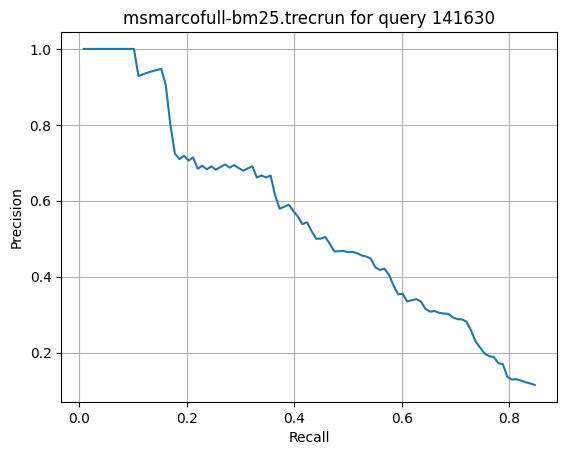

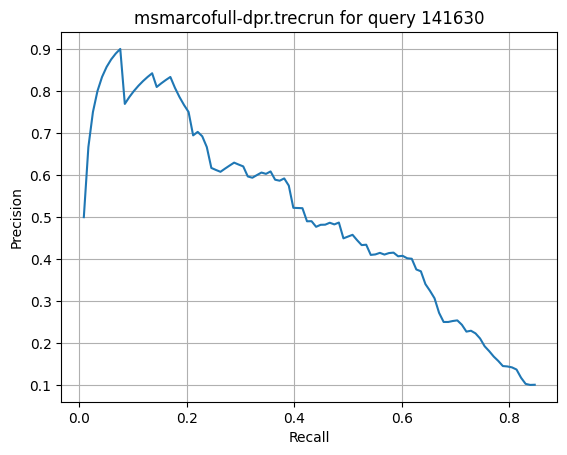

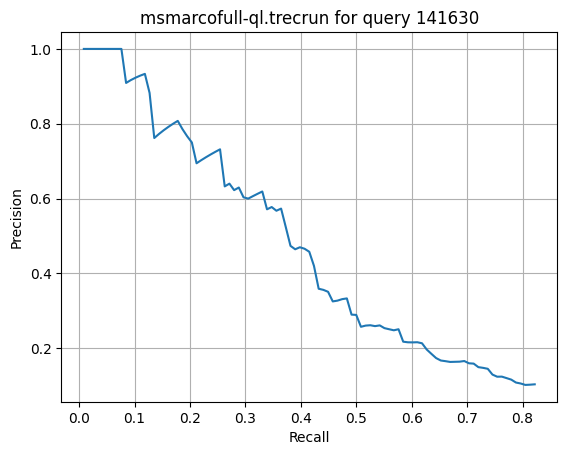

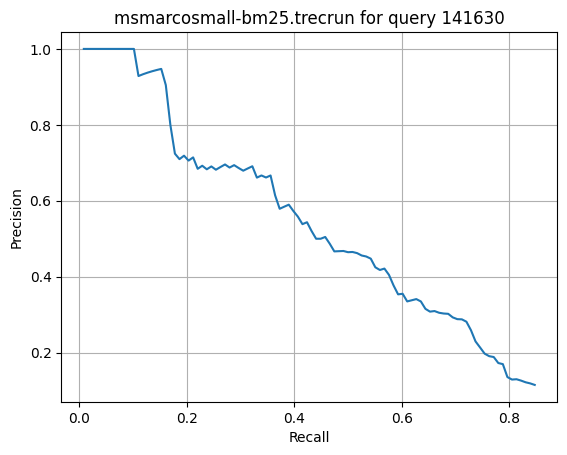

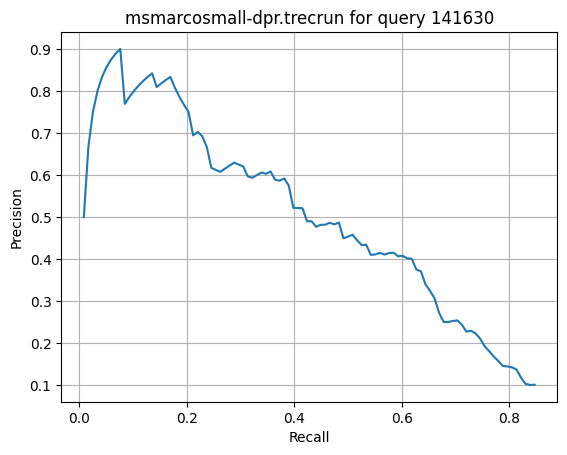

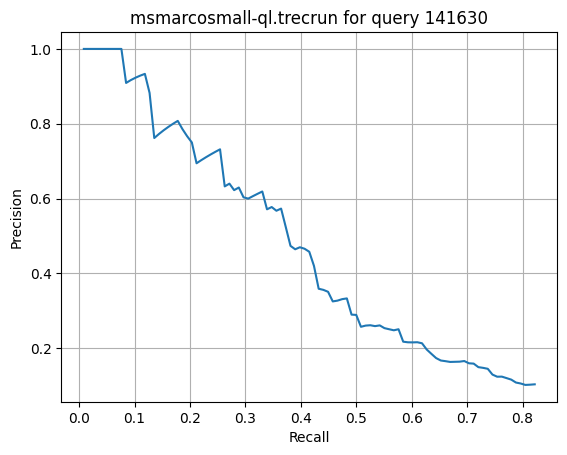

In [303]:
import matplotlib.pyplot as plt
def get_points(queriesDict: QueryInfo) -> tuple[list[int], list[int]]: # list[(x, y)] -> x is precision, and y is recall
    # add a new point to the return list, everytime a relevant document is encountered in the ranked list
    recall_x_lst = []
    precision_y_lst = []
    relevant_count = 0
    total_relevant_count = numRel(query=queriesDict) # get total amount of relevant documents for this query
    for i, doc_id in enumerate(queriesDict.trecrun_dict.keys(), start=1):   # ranked list         
        if doc_id in queriesDict.qrel_dict.keys() and queriesDict.qrel_dict[doc_id] > '0': # document is relevant                
            relevant_count += 1
            precision_y_lst.append(relevant_count/i)   # number of relevanat / total number of retrieved documents at the ith iteration
            recall_x_lst.append(relevant_count/total_relevant_count) # number of relevant now retrieved / total number relevant

    return recall_x_lst, precision_y_lst 

def recall_precision_graph() -> None:
    query_to_graph = "141630"
    trecrun_dict = {} # {trecrun_file_location: query_dict}
    for file in trecrun_files: 
        if file not in trecrun_dict.keys():
            trecrun_dict[file] = {}
            read_trecrun(trecRunFile=file, queriesDict=trecrun_dict[file])
            read_qrels(qrelsFile=qrels_file, queriesDict=trecrun_dict[file])
    
    for model, model_dict in trecrun_dict.items():
        for query_id, query_obj in model_dict.items():
            if query_id == query_to_graph:
                x, y = get_points(queriesDict=query_obj)
                plot_graph(name=model.lstrip("./data/") + " for query " + query_to_graph, x=x, y=y)   # i.e., model = "./data/msmarcosmall-bm25.trecrun" 

def plot_graph(name: str, x: list, y: list) -> None:
    plt.figure()
    plt.plot(x, y)
    plt.xlabel("Recall")    
    plt.ylabel("Precision")    
    plt.title(name)
    plt.grid()
    plt.show()
                
recall_precision_graph()

## 4.5 Recall / precision interpolation (extra credit)

Repeat 4.4 but graph it for recall values of 0.0 through 1.0 at intervals of 0.1, with the precision values interpolated as presented in class.

Depending on how you implemented the graphing function for 4.4, you may be able to use the same one you used above.

In [304]:
# Maybe a new graphing function

# Produce the graph

# 5. Misc & Grading

**WARNING: Points breakdown may shift with a later version. This gives you an idea of what we are expecting to do.**

Your P2 submission is graded out of 100 points, allocated as follows:
* 75 points for the code (these are autograded)
  * 6 points: 3 points each for correctly calculating `numRel` and `relFound` on all six run files
  * 24 points: 6 points each for correctly calculating `RR`, `P@13`, `R@13`, and `F1@13` on all six run files
  * 45 points: 15 points each for correctly calculating `NDCG@23`, `AP`, and `BPREF` on all six run files
  * Up to 6 points extra credit for P@29R and P@R on all six run files

* 25 points for the analysis questions (these are graded manually):
  * 10 points for correctness of generated table (4.1)
  * 2 points for interpretation of generated table (4.2)
  * 3 points for discussion of MAP (4.3)
  * 10 points for correctness of recall/precision graph (4.4)
  * Up to 4 points for extra credit interpolation graph (4.5)

Note that we expect that you will upload your submission in the correct format (notebook and PDF), that the code in the notebook will run, and that the code will successfully process provided trecrun files, possibly including some you do not have access to.